# Add an Image: Productivity Across the Entire 15-day Period

We investigate the effect of having Add an Image as the default task on the number of edits a newcomer makes across the whole time period of interest, which covers both their first day and the subsequent two weeks.

In [1]:
library(tidyverse)
library(broom)

library(brms) # install.packages("brms")
library(loo) # install.packages("loo")
library(rstanarm) # install.packages("rstanarm")

library(lubridate)
library(bayesplot)

# library(lme4)
# library(yardstick) # install.packages("yardstick")

# library(caret)

Warning message:
“package ‘tidyverse’ was built under R version 4.2.3”
Warning message:
“package ‘tibble’ was built under R version 4.2.3”
Warning message:
“package ‘tidyr’ was built under R version 4.2.3”
Warning message:
“package ‘readr’ was built under R version 4.2.3”
Warning message:
“package ‘purrr’ was built under R version 4.2.3”
Warning message:
“package ‘dplyr’ was built under R version 4.2.3”
Warning message:
“package ‘stringr’ was built under R version 4.2.3”
Warning message:
“package ‘forcats’ was built under R version 4.2.3”
Warning message:
“package ‘lubridate’ was built under R version 4.2.3”
── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.2     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.3     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.1     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()

# R Configuration variables

In [2]:
## NOTE: `loo`, which we use for model comparisons, has a tendency to use lots or run out of memory.
## Therefore, I've often had to set mc.cores to 1 before running it. However, if we set its `pointwise`
## parameter, it'll use less memory. And it'll use BLAS, so we restrict the number of BLAS threads to 1.
## Then mc.cores controls the number of parallel processes.

## blas_set_num_threads() also controls the number of threads that glmer() uses. Depending on the load
## on the server at the time we're doing our analysis we can tune the number of threads.

library(RhpcBLASctl)
blas_set_num_threads(1)
options(mc.cores = 4, digits = 3, scipen = 500)

# Give me wider plots, please
options(repr.plot.width = 14, repr.plot.height = 7)

Warning message:
“package ‘RhpcBLASctl’ was built under R version 4.2.3”


# Helper functions

In [3]:
## Function that takes in a model, the validation set, the name of the predicted column,
## and returns a plot of the ROC curve
plot_ROC <- function(mod, val_data, col_name) {
    val_data$estimate = predict(mod, val_data, type = "response")
    roc_curve(val_data, {{ col_name }}, estimate, event_level = 'second') %>%
        ggplot(aes(x = 1 - specificity, y = sensitivity)) +
        geom_path() +
        geom_abline(lty = 3) +
        coord_equal() +
        theme_bw()
}

In [4]:
## Function that takes in the filename of the user edit data, reads it in,
## and creates all the various derived columns we need.
read_user_dataset <- function(dataset_filename) {
    read_tsv(
        dataset_filename,
        col_types = user_dataset_column_types) %>%
    mutate(
        Group = factor(hp_enabled, levels = c(0, 1), labels = c("C", "HP")),
        platform = factor(reg_on_mobile == 1, c(FALSE, TRUE), c("desktop", "mobile")),
        ## Registration month, for later joins on month
        reg_month = floor_date(user_registration_timestamp, unit = 'month'),
        # Number of edits:
        num_total_edits_24hrs = num_article_edits_24hrs + num_other_edits_24hrs,
        num_total_edits_2w = num_article_edits_2w + num_other_edits_2w,
        num_total_edits = num_total_edits_24hrs + num_total_edits_2w,
        num_total_article_edits = num_article_edits_24hrs + num_article_edits_2w,
        num_total_other_edits = num_other_edits_24hrs + num_total_edits_2w,
        # Log number of total edits is used as a control variable in the revert analysis
        log_num_total_edits = log(1 + num_total_edits),
        # Number of reverts:
        num_reverts_24hrs = num_article_reverts_24hrs + num_other_reverts_24hrs,
        num_reverts_2w = num_article_reverts_2w + num_other_reverts_2w,
        num_total_reverts = num_reverts_24hrs + num_reverts_2w,
        ## Control variables for the number of edits made (used for ex. in revert analysis)
        log_num_article_edits_24hrs = log(1 + num_article_edits_24hrs),
        log_num_other_edits_24hrs = log(1 + num_other_edits_24hrs),
        log_num_edits_24hrs = log(1 + num_article_edits_24hrs + num_other_edits_24hrs),
        # Control variables for the number of constructive edits made
        log_num_const_article_edits_24hrs = log(
            1 + num_article_edits_24hrs - num_article_reverts_24hrs),
        log_num_const_other_edits_24hrs = log(
            1 + num_other_edits_24hrs - num_other_reverts_24hrs),
        log_num_const_edits_24hrs = log(
            1 + num_article_edits_24hrs + num_other_edits_24hrs -
                num_article_reverts_24hrs - num_other_reverts_24hrs),
        # Revert rate:
        prop_rev_edits = ifelse(num_total_edits > 0, num_total_reverts / num_total_edits, 0),
        # Did they activate?
        is_activated_article = num_article_edits_24hrs > 0,
        is_activated_other = num_other_edits_24hrs > 0,
        is_activated = is_activated_article | is_activated_other,
        # Did they activate through constructive edits?
        is_const_activated_article = (num_article_edits_24hrs - num_article_reverts_24hrs) > 0,
        is_const_activated_other = (num_other_edits_24hrs - num_other_reverts_24hrs) > 0,
        is_const_activated = is_const_activated_article | is_const_activated_other,
        # Were they retained?
        is_retained_article = is_activated_article & (num_article_edits_2w > 0),
        is_retained_other = is_activated_other & (num_other_edits_2w > 0),
        is_retained = is_activated & ((num_article_edits_2w + num_other_edits_2w) > 0),
        # Were they retained through constructive edits?
        is_const_retained_article = is_const_activated_article &
            ((num_article_edits_2w - num_article_reverts_2w) > 0),
        is_const_retained_other = is_const_activated_other &
            ((num_other_edits_2w - num_other_reverts_2w) > 0),
        is_const_retained = is_const_activated &
            ((num_article_edits_2w + num_other_edits_2w -
              num_article_reverts_2w - num_other_reverts_2w) > 0)
    ) 
}

In [5]:
## Function that takes in the filename of the active editors dataset,
## and adds a registration month column for easy joining with the user dataset.
read_active_editors_dataset <- function(dataset_filename) {
    read_tsv(
        dataset_filename,
        col_types = active_editors_column_types) %>%
    mutate(wiki_db = factor(wiki_db),
           reg_month = month + months(1))
}

# Experiment Configuration Variables

We define a set of configuration variables that are useful for the analysis. One obvious one is where the edit dataset is located.

A less obvious one is a variable for when the experiment started. We often use this seeking to model the community's initial response to changes in newcomer behaviour, as well as long-term trends in the outcome variable when working with user data gathered across a relatively long time period.

In [6]:
## Path to the datasets with user edits
user_dataset_filenames <- c(
    '/home/nettrom/src/2021-Growth-structured-tasks/datasets/add-an-image-edit-data.tsv'
    )

## Column types in the dataset: wiki is a factor, HP variant is a factor, registration is a date time,
## everything else are integers.
user_dataset_column_types <- 'fiTiifiiiiiiii'

## Path to the dataset with counts of the number of active editors
active_editors_filenames <- c()

## Column types in the active editors dataset: month is a date, wiki is a factor
active_editors_column_types <- 'Dfiii'

## Deployment timestamps for Add an Image on each of the wikis
## This is not relevant for this, because we "reset" the experiment and
## gather data well after deployment.
exp_start_timestamps <- tribble(
    ~wiki_db, ~exp_start_timestamp,
    'arwiki', ymd_hms('2021-05-27 19:12:03', tz = 'UTC'),

) %>% mutate(wiki_db = factor(wiki_db))

## Path to the dataset with editing status at account registration
editing_status_filenames <- c()

## Column types in the editing status dataset: wiki is a factor, everything else are integers
editing_status_column_types <- 'fii'

## Path to the dataset with Welcome Survey responses
survey_response_filenames <- c()

## Columns types in the survey response data: user ID is an integer, number of languages is a number,
## everything else are factors
survey_response_column_types <- 'fifffn'

# Data import and setup

In [7]:
user_edit_data <- map_dfr(user_dataset_filenames, read_user_dataset)

In [8]:
nrow(user_edit_data)

[1] 148419

## Time since experiment start

Join the edits data with the experiment timestamps and measure time since the start to enable controlling for that:

Made sure that we're not dropping any users at this stage, we're good to move forward.

## Additional variables

We've previously focused on Control vs Growth Features in our analysis. In this case we'll focus primarily on Unstructured Link Task vs Add a Link, but also check against the control group. This means we want the single variable `Group` to reflect one of three options depending on `hp_enabled` and `hp_variant`

In [9]:
user_edit_data <- user_edit_data %>%
    mutate(
        platform = ifelse(reg_on_mobile == 1, 'Mobile web', 'Desktop'),
        exp_group = factor(
            ifelse(
                hp_enabled == 0, 'Control',
                ifelse(hp_variant == 'control',
                       'Add-a-Link', 'Add-an-Image')
            ),
            c('Control', 'Add-a-Link', 'Add-an-Image')
        )
    )

Our productivity model will fit on the total number of constructive article edits, so we need a variable for that.

In [10]:
user_edit_data <- user_edit_data %>%
    mutate(num_total_const_article_edits = num_article_edits_24hrs - num_article_reverts_24hrs +
           num_article_edits_2w - num_article_reverts_2w)

## Checking number of accounts for each wiki

We might be looking at very small wikis, in case we might want to not include them in the analysis.

In [ ]:
user_edit_data %>%
    group_by(wiki_db, exp_group) %>%
    summarize(n = n())

As we noted for the activation and retention analyses, we have to exclude French Wikipedia from analysis where all three experiment groups are compared since it didn't have a full control group.

## Splitting into Training, Test, and Validation Datasets

Split the dataset into training, test, and validation data sets.

In [ ]:
## set the random seed so train/test/validation splits can be reproduced
set.seed(42)

trainIndex <- caret::createDataPartition(user_edit_data$Group,
                                         p = .8,
                                         list = FALSE,
                                         times = 1)
user_data_train = user_edit_data[trainIndex,]
user_data_second = user_edit_data[-trainIndex,]

testIndex = caret::createDataPartition(user_data_second$Group, p = .5, list = FALSE, times = 1)

user_data_test = user_data_second[testIndex,]
user_data_validate = user_data_second[-testIndex,]

In [ ]:
user_data_test$is_activated_fct <- factor(user_data_test$is_activated,
                                          labels = c('No', 'Yes'))
user_data_validate$is_activated_fct <- factor(user_data_validate$is_activated,
                                          labels = c('No', 'Yes'))

## Visualizing Productivity

We'll make box plots of editing based on group, and we'll focus on constructive article edits because that's where we see the strongest effects. This plot uses the `log10(1 + x)` transformation so we get to see all users who didn't make any edits.

In [ ]:
user_edit_data |>
    filter(wiki_db != 'frwiki') |>
    mutate(log_num_total_const_article_edits = log10(1 + num_article_edits_24hrs - num_article_reverts_24hrs +
           num_article_edits_2w - num_article_reverts_2w)) |>
    ggplot(aes(x = exp_group, y = log_num_total_const_article_edits)) +
        labs(title = 'Productivity by Group', yaxis_title = 'Number of constructive edits (log 10 scale)') +
        geom_boxplot()

It looks like there are some interesting differences between the groups when it comes to the distribution of the number of edits. Let's summarize per group.

In [ ]:
user_edit_data |>
    filter(wiki_db != 'frwiki') |>
    mutate(num_total_const_article_edits = num_article_edits_24hrs - num_article_reverts_24hrs +
           num_article_edits_2w - num_article_reverts_2w) |>
    group_by(platform, exp_group) |>
    summarise(min_edits = min(num_total_const_article_edits),
              perc_5_edits = quantile(num_total_const_article_edits, probs = c(0.05)),
              perc_10_edits = quantile(num_total_const_article_edits, probs = c(0.1)),
              perc_25_edits = quantile(num_total_const_article_edits, probs = c(0.25)),
              median_edits = median(num_total_const_article_edits),
              mean_edits = mean(num_total_const_article_edits),
              perc_75_edits = quantile(num_total_const_article_edits, probs = c(0.75)),
              perc_90_edits = quantile(num_total_const_article_edits, probs = c(0.9)),
              perc_95_edits = quantile(num_total_const_article_edits, probs = c(0.95)),
              max_edits = max(num_total_const_article_edits),
             .groups = 'keep'
             )

## Priors

In [14]:
## Note that using a student_t distribution for the prior is beneficial because that
## distribution handles outliers better than a Normal.
## See https://jrnold.github.io/bayesian_notes/robust-regression.html
## Thanks to Mikhail for sending that to me!
priors <- prior(cauchy(0, 2), class = sd) +
  prior(student_t(5, 0, 10), class = b)

# Constructive Article Productivity with Group-level Variation

In the analysis of activation, we found meaningful group-level variation in `platform`, and indications of an interaction between `platform` and `Group`. When analysing retention, we found that it mainly followed activation. This analysis is slightly different in that we'll count all edits across the entire time period (in other words, users can activate after the first 24 hours and it'll matter). We'll start with a model that's similar to the activation model, and then fit one or two competing models for later checking with `loo`.

In [ ]:
## Note: Don't forget to add `save_pars = save_pars(all = TRUE)` as parameters to brm() so that
## loo() can use `moment_match = TRUE` as well

constr.article.edits.all.days.zinb.1 <- 
    brm(
        bf(
            num_total_const_article_edits ~ platform * exp_group + (1 + platform | wiki_db),
            zi ~ platform + (1 + platform | wiki_db)
        ),
        data = filter(user_edit_data, wiki_db != 'frwiki'),
        family = zero_inflated_negbinomial(),
        prior = priors,
        iter = 400,
        control = list(adapt_delta = 0.99,
                       max_treedepth = 15)
    )

Compiling Stan program...

Start sampling



In [19]:
## Save the model
save(constr.article.edits.all.days.zinb.1,
     file='models/constr.article.edits.all.days.zinb.1.Robj')

In [20]:
summary(constr.article.edits.all.days.zinb.1)

 Family: zero_inflated_negbinomial 
  Links: mu = log; shape = identity; zi = logit 
Formula: num_total_const_article_edits ~ platform * exp_group + (1 + platform | wiki_db) 
         zi ~ platform + (1 + platform | wiki_db)
   Data: filter(user_edit_data, wiki_db != "frwiki") (Number of observations: 110389) 
  Draws: 4 chains, each with iter = 400; warmup = 200; thin = 1;
         total post-warmup draws = 800

Group-Level Effects: 
~wiki_db (Number of levels: 6) 
                                       Estimate Est.Error l-95% CI u-95% CI
sd(Intercept)                              0.62      0.27     0.33     1.32
sd(platformMobileweb)                      0.51      0.19     0.26     1.01
sd(zi_Intercept)                           4.43      1.62     2.36     8.74
sd(zi_platformMobileweb)                   3.28      1.22     1.46     5.83
cor(Intercept,platformMobileweb)          -0.60      0.32    -0.94     0.28
cor(zi_Intercept,zi_platformMobileweb)    -0.65      0.31    -0.98     0.

We do not find clear indications of an interaction effect. Add an Image on mobile web gets close, which corresponds well to our activation findings.

In [76]:
geomean.by.platform <- user_edit_data %>%
    filter(wiki_db != 'frwiki') |>
    group_by(platform, exp_group) %>%
    summarize(geomean = exp(mean(log(1 + num_total_const_article_edits))) -1,
              propzero = sum(ifelse(num_total_const_article_edits == 0, 1, 0))/n())
geomean.by.platform

`summarise()` has grouped output by 'platform'. You can override using the
`.groups` argument.


platform   exp_group    geomean propzero
1 Desktop    Control      0.324   0.761   
2 Desktop    Add-a-Link   0.345   0.749   
3 Desktop    Add-an-Image 0.334   0.760   
4 Mobile web Control      0.233   0.819   
5 Mobile web Add-a-Link   0.275   0.797   
6 Mobile web Add-an-Image 0.284   0.792

In [ ]:
user_edit_data %>%
    filter(num_total_const_article_edits > 0) %>%
    group_by(exp_group) %>%
    summarize(mean = mean(num_total_const_article_edits),
              median = median(num_total_const_article_edits),
              geomean = exp(mean(log(num_total_const_article_edits))))

In [ ]:
pp_check(constr.article.edits.all.days.zinb.1,
         ndraws = 100, type = "bars_grouped", group = "wiki_db") +
  ggplot2::coord_cartesian(xlim = c(0, 10));

Zooming in on the non-zero part of the distributions, because the high zero-rate results in such a compressed graph.

In [ ]:
pp_check(constr.article.edits.all.days.zinb.1,
         ndraws = 100, type = "bars_grouped", group = "wiki_db") +
  ggplot2::coord_cartesian(xlim = c(1, 10), ylim = c(0, 5000));

Getting the incident rate for Add a Link, with the 95% credible interval:

In [ ]:
fixef(constr.article.edits.all.days.zinb.1)

In [ ]:
exp(fixef(constr.article.edits.all.days.zinb.1)[5,"Estimate"])

In [ ]:
exp(fixef(constr.article.edits.all.days.zinb.1)[5,"Q2.5"])

In [ ]:
exp(fixef(constr.article.edits.all.days.zinb.1)[5,"Q97.5"])

Let's use the geometric mean from before to calculate the increase this time.

In [99]:
# Add an Image: desktop increase

round(geomean.by.platform[3, 'geomean'] - geomean.by.platform[1, 'geomean'], 3)

geomean
1 0.01

In [82]:
# Add an Image: desktop increase per 1,000 newcomers

round(1000 * (geomean.by.platform[3, 'geomean'] - geomean.by.platform[1, 'geomean']), 2)

geomean
1 9.79

In [101]:
# Add an Image: relative desktop increase in percent, rounded

round(100 * (geomean.by.platform[3, 'geomean'] - geomean.by.platform[1, 'geomean']) /
    geomean.by.platform[1, 'geomean'], 1)

geomean
1 3

In [103]:
# Add a Link: desktop increase

round(geomean.by.platform[2, 'geomean'] - geomean.by.platform[1, 'geomean'], 3)

geomean
1 0.021

In [86]:
# Add a Link: desktop increase per 1,000 newcomers

round(1000 * (geomean.by.platform[2, 'geomean'] - geomean.by.platform[1, 'geomean']), 2)

geomean
1 21.2

In [87]:
# Add a Link: relative desktop increase in percent, rounded

round(100 * (geomean.by.platform[2, 'geomean'] - geomean.by.platform[1, 'geomean']) /
    geomean.by.platform[1, 'geomean'], 1)

geomean
1 6.6

Same calculations for the mobile web platform:

In [104]:
# Add an Image: mobile web increase

round(geomean.by.platform[6, 'geomean'] - geomean.by.platform[4, 'geomean'], 3)

geomean
1 0.051

In [89]:
# Add an Image: mobile web increase per 1,000 newcomers

round(1000 * (geomean.by.platform[6, 'geomean'] - geomean.by.platform[4, 'geomean']), 2)

geomean
1 50.9

In [90]:
# Add an Image: relative mobile web increase in percent, rounded

round(100 * (geomean.by.platform[6, 'geomean'] - geomean.by.platform[4, 'geomean']) /
    geomean.by.platform[4, 'geomean'], 1)

geomean
1 21.8

In [105]:
# Add a Link: mobile web increase

round(geomean.by.platform[5, 'geomean'] - geomean.by.platform[4, 'geomean'], 3)

geomean
1 0.042

In [91]:
# Add a Link: mobile web increase per 1,000 newcomers

round(1000 * (geomean.by.platform[5, 'geomean'] - geomean.by.platform[4, 'geomean']), 2)

geomean
1 42

In [92]:
# Add a Link: relative desktop increase in percent, rounded

round(100 * (geomean.by.platform[5, 'geomean'] - geomean.by.platform[4, 'geomean']) /
    geomean.by.platform[4, 'geomean'], 1)

geomean
1 18

Difference between the two structured tasks:

In [93]:
# Add an Image: desktop difference to Add a Link per 1,000 newcomers

round(1000 * (geomean.by.platform[3, 'geomean'] - geomean.by.platform[2, 'geomean']), 2)

geomean
1 -11.4

In [94]:
# Add an Image: relative desktop differente to Add a Link in percent, rounded

round(100 * (geomean.by.platform[3, 'geomean'] - geomean.by.platform[2, 'geomean']) /
    geomean.by.platform[2, 'geomean'], 1)

geomean
1 -3.3

In [95]:
# Add an Image: Mobile web difference to Add a Link per 1,000 newcomers

round(1000 * (geomean.by.platform[6, 'geomean'] - geomean.by.platform[5, 'geomean']), 2)

geomean
1 8.94

In [96]:
# Add an Image: relative desktop differente to Add a Link in percent, rounded

round(100 * (geomean.by.platform[6, 'geomean'] - geomean.by.platform[5, 'geomean']) /
    geomean.by.platform[5, 'geomean'], 1)

geomean
1 3.2

Geometric means if we exclude all users who made 0 edits:

In [ ]:
control.geomean.nonzero <- exp(
    mean(
        log(
            user_edit_data[(user_edit_data$Group == "Control") &
                           (user_edit_data$num_total_const_article_edits > 0),]$num_total_const_article_edits
        )
    )
)
round(control.geomean.nonzero, 3)

In [ ]:
unstructured.geomean.nonzero <- exp(
    mean(
        log(
            user_edit_data[(user_edit_data$Group == "Unstructured") &
                               (user_edit_data$num_total_const_article_edits > 0),]$num_total_const_article_edits
        )
    )
)
round(unstructured.geomean.nonzero, 3)

In [ ]:
addalink.geomean.nonzero <- exp(
    mean(
        log(
            user_edit_data[(user_edit_data$Group == "Add-a-link") &
                           (user_edit_data$num_total_const_article_edits > 0),]$num_total_const_article_edits
        )
    )
)
round(addalink.geomean.nonzero, 3)

In [ ]:
round(unstructured.geomean.nonzero - control.geomean.nonzero, 3)

In [ ]:
round(addalink.geomean.nonzero - control.geomean.nonzero, 3)

In [ ]:
round(100 * (unstructured.geomean.nonzero - control.geomean.nonzero) / control.geomean.nonzero, 1)

In [ ]:
round(100 * (addalink.geomean.nonzero - control.geomean.nonzero) / control.geomean.nonzero, 1)

In [ ]:
user_edit_data %>%
    group_by(platform, Group) %>%
    summarise(geo_mean = exp(mean(log(1 + num_total_const_article_edits))) -1)

## Model without interaction effects

In [ ]:
constr.article.edits.all.days.zinb.2 <- 
    brm(
        bf(
            num_total_const_article_edits ~ platform + exp_group + (1 + platform | wiki_db),
            zi ~ platform + (1 + platform | wiki_db)
        ),
        data = filter(user_edit_data, wiki_db != 'frwiki'),
        family = zero_inflated_negbinomial(),
        prior = priors,
        iter = 300,
        control = list(adapt_delta = 0.99,
                       max_treedepth = 15),
        save_pars = save_pars(all = TRUE)
    )

Compiling Stan program...

Start sampling



In [ ]:
## Save the model
save(constr.article.edits.all.days.zinb.2,
     file='models/constr.article.edits.all.days.zinb.2.Robj')

In [27]:
summary(constr.article.edits.all.days.zinb.2)

 Family: zero_inflated_negbinomial 
  Links: mu = log; shape = identity; zi = logit 
Formula: num_total_const_article_edits ~ platform + exp_group + (1 + platform | wiki_db) 
         zi ~ platform + (1 + platform | wiki_db)
   Data: filter(user_edit_data, wiki_db != "frwiki") (Number of observations: 110389) 
  Draws: 4 chains, each with iter = 300; warmup = 150; thin = 1;
         total post-warmup draws = 600

Group-Level Effects: 
~wiki_db (Number of levels: 6) 
                                       Estimate Est.Error l-95% CI u-95% CI
sd(Intercept)                              0.61      0.25     0.32     1.27
sd(platformMobileweb)                      0.51      0.22     0.25     1.04
sd(zi_Intercept)                           4.57      1.65     2.43     8.70
sd(zi_platformMobileweb)                   3.38      1.63     1.51     7.22
cor(Intercept,platformMobileweb)          -0.61      0.29    -0.95     0.07
cor(zi_Intercept,zi_platformMobileweb)    -0.61      0.32    -0.98     0.

## Model with group-level variation in experiment group

In [ ]:
constr.article.edits.all.days.zinb.3 <- 
    brm(
        bf(
            num_total_const_article_edits ~ platform + exp_group + (1 + platform + exp_group | wiki_db),
            zi ~ platform + (1 + platform | wiki_db)
        ),
        data = filter(user_edit_data, wiki_db != 'frwiki'),
        family = zero_inflated_negbinomial(),
        prior = priors,
        iter = 300,
        control = list(adapt_delta = 0.99,
                       max_treedepth = 15),
        save_pars = save_pars(all = TRUE)
    )

Compiling Stan program...

Start sampling



In [ ]:
## Save the model
save(constr.article.edits.all.days.zinb.3,
     file='models/constr.article.edits.all.days.zinb.3.Robj')

In [30]:
summary(constr.article.edits.all.days.zinb.3)

Warning message:
“The ESS has been capped to avoid unstable estimates.”


 Family: zero_inflated_negbinomial 
  Links: mu = log; shape = identity; zi = logit 
Formula: num_total_const_article_edits ~ platform + exp_group + (1 + platform + exp_group | wiki_db) 
         zi ~ platform + (1 + platform | wiki_db)
   Data: filter(user_edit_data, wiki_db != "frwiki") (Number of observations: 110389) 
  Draws: 4 chains, each with iter = 300; warmup = 150; thin = 1;
         total post-warmup draws = 600

Group-Level Effects: 
~wiki_db (Number of levels: 6) 
                                               Estimate Est.Error l-95% CI
sd(Intercept)                                      0.66      0.29     0.31
sd(platformMobileweb)                              0.52      0.20     0.26
sd(exp_groupAddMaMLink)                            0.33      0.15     0.14
sd(exp_groupAddManMImage)                          0.16      0.09     0.04
sd(zi_Intercept)                                   4.42      1.48     2.43
sd(zi_platformMobileweb)                           3.15      1.21  

In [ ]:
print(ranef(constr.article.edits.all.days.zinb.3))

Based on these estimates, it looks like the group-level effect in `exp_group` is not strong, they're largely estimated to be zero. The same also goes for the effect of `platform` on zero-inflation, it doesn't seem meaningful to allow that estimator to have group-level variation.

We therefore fit a variation of Model 2 that does not have group-level variation in `platform` for zero-inflation, and compare it to Model 2.

## Model without zero-inflation group-level variation in platform

In [ ]:
constr.article.edits.all.days.zinb.5 <- 
    brm(
        bf(
            num_total_const_article_edits ~ platform + exp_group + (1 + platform | wiki_db),
            zi ~ platform + (1 | wiki_db)
        ),
        data = filter(user_edit_data, wiki_db != 'frwiki'),
        family = zero_inflated_negbinomial(),
        prior = priors,
        iter = 300,
        control = list(adapt_delta = 0.99,
                       max_treedepth = 15),
        save_pars = save_pars(all = TRUE)
    )

Compiling Stan program...

Start sampling



In [ ]:
## Save the model
save(constr.article.edits.all.days.zinb.5,
     file='models/constr.article.edits.all.days.zinb.5.Robj')

In [39]:
summary(constr.article.edits.all.days.zinb.5)

 Family: zero_inflated_negbinomial 
  Links: mu = log; shape = identity; zi = logit 
Formula: num_total_const_article_edits ~ platform + exp_group + (1 + platform | wiki_db) 
         zi ~ platform + (1 | wiki_db)
   Data: filter(user_edit_data, wiki_db != "frwiki") (Number of observations: 110389) 
  Draws: 4 chains, each with iter = 300; warmup = 150; thin = 1;
         total post-warmup draws = 600

Group-Level Effects: 
~wiki_db (Number of levels: 6) 
                                 Estimate Est.Error l-95% CI u-95% CI Rhat
sd(Intercept)                        0.61      0.25     0.33     1.23 1.02
sd(platformMobileweb)                0.54      0.20     0.29     1.02 1.01
sd(zi_Intercept)                     4.18      1.67     2.00     8.38 1.01
cor(Intercept,platformMobileweb)    -0.61      0.28    -0.95     0.06 1.02
                                 Bulk_ESS Tail_ESS
sd(Intercept)                         230      373
sd(platformMobileweb)                 282      340
sd(zi_Interc

### Model comparisons using `loo`


In [45]:
constr.article.edits.all.days.zinb.5.loo = loo(
    constr.article.edits.all.days.zinb.5,
    pointwise = TRUE,
    moment_match = TRUE
)

Warning message:
“Some Pareto k diagnostic values are too high. See help('pareto-k-diagnostic') for details.
”
Warning message:
“Found 1 observations with a pareto_k > 0.7 in model 'constr.article.edits.all.days.zinb.5'. It is recommended to set 'reloo = TRUE' in order to calculate the ELPD without the assumption that these observations are negligible. This will refit the model 1 times to compute the ELPDs for the problematic observations directly.”


In [42]:
constr.article.edits.all.days.zinb.1.loo = loo(
    constr.article.edits.all.days.zinb.1,
    pointwise = TRUE,
    moment_match = TRUE
)

Warning message:
“Found 2 observations with a pareto_k > 0.7 in model 'constr.article.edits.all.days.zinb.1'. It is recommended to set 'moment_match = TRUE' in order to perform moment matching for problematic observations. ”


In [50]:
constr.article.edits.all.days.zinb.2.loo = loo(
    constr.article.edits.all.days.zinb.2,
    pointwise = TRUE
)

Warning message:
“Found 3 observations with a pareto_k > 0.7 in model 'constr.article.edits.all.days.zinb.2'. It is recommended to set 'moment_match = TRUE' in order to perform moment matching for problematic observations. ”


In [47]:
constr.article.edits.all.days.zinb.3.loo = loo(
    constr.article.edits.all.days.zinb.3,
    pointwise = TRUE,
    moment_match = TRUE
)

Warning message:
“Some Pareto k diagnostic values are too high. See help('pareto-k-diagnostic') for details.
”
Warning message:
“Found 2 observations with a pareto_k > 0.7 in model 'constr.article.edits.all.days.zinb.3'. It is recommended to set 'reloo = TRUE' in order to calculate the ELPD without the assumption that these observations are negligible. This will refit the model 2 times to compute the ELPDs for the problematic observations directly.”


In [51]:
loo_compare(
    constr.article.edits.all.days.zinb.1.loo,
    constr.article.edits.all.days.zinb.2.loo,
    constr.article.edits.all.days.zinb.3.loo,
    constr.article.edits.all.days.zinb.5.loo
)

elpd_diff se_diff elpd_loo se_elpd_loo
constr.article.edits.all.days.zinb.3    0.00    0.0    -105300  555        
constr.article.edits.all.days.zinb.2   -5.42   15.9    -105305  555        
constr.article.edits.all.days.zinb.1  -10.46   16.8    -105310  556        
constr.article.edits.all.days.zinb.5 -103.83   27.4    -105403  556        
                                     p_loo se_p_loo looic  se_looic
constr.article.edits.all.days.zinb.3 121.8 13.38    210599 1109    
constr.article.edits.all.days.zinb.2  86.0  9.89    210610 1111    
constr.article.edits.all.days.zinb.1  96.5 11.44    210620 1111    
constr.article.edits.all.days.zinb.5  86.3 10.41    210807 1112

Based on these results, Model 2 is the preferred choice. It has the least amount of complexity, and the difference in `elpd` is not significant.

## Model with no control group – includes French Wikipedia

In [31]:
constr.article.edits.all.days.zinb.4 <- 
    brm(
        bf(
            num_total_const_article_edits ~ platform + exp_group + (1 + platform | wiki_db),
            zi ~ platform + (1 + platform | wiki_db)
        ),
        data = filter(user_edit_data, exp_group != 'Control'),
        family = zero_inflated_negbinomial(),
        prior = priors,
        iter = 300,
        control = list(adapt_delta = 0.99,
                       max_treedepth = 15),
        save_pars = save_pars(all = TRUE)
    )

Compiling Stan program...

Start sampling

Warning message:
“Bulk Effective Samples Size (ESS) is too low, indicating posterior means and medians may be unreliable.
Running the chains for more iterations may help. See
https://mc-stan.org/misc/warnings.html#bulk-ess”
Warning message:
“Tail Effective Samples Size (ESS) is too low, indicating posterior variances and tail quantiles may be unreliable.
Running the chains for more iterations may help. See
https://mc-stan.org/misc/warnings.html#tail-ess”


In [32]:
## Save the model
save(constr.article.edits.all.days.zinb.4,
     file='models/constr.article.edits.all.days.zinb.4.Robj')

In [ ]:
print(ranef(constr.article.edits.all.days.zinb.4))

In [33]:
summary(constr.article.edits.all.days.zinb.4)

 Family: zero_inflated_negbinomial 
  Links: mu = log; shape = identity; zi = logit 
Formula: num_total_const_article_edits ~ platform + exp_group + (1 + platform | wiki_db) 
         zi ~ platform + (1 + platform | wiki_db)
   Data: filter(user_edit_data, exp_group != "Control") (Number of observations: 126401) 
  Draws: 4 chains, each with iter = 300; warmup = 150; thin = 1;
         total post-warmup draws = 600

Group-Level Effects: 
~wiki_db (Number of levels: 7) 
                                       Estimate Est.Error l-95% CI u-95% CI
sd(Intercept)                              0.48      0.19     0.27     0.90
sd(platformMobileweb)                      0.38      0.15     0.20     0.71
sd(zi_Intercept)                           3.96      1.33     2.26     7.06
sd(zi_platformMobileweb)                   3.25      1.21     1.78     5.92
cor(Intercept,platformMobileweb)          -0.54      0.29    -0.92     0.17
cor(zi_Intercept,zi_platformMobileweb)    -0.89      0.14    -1.00    

We now refit the model with 1,000 iterations to improve the estimates.

In [ ]:
constr.article.edits.all.days.zinb.structured.full <- 
    brm(
        bf(
            num_total_const_article_edits ~ platform + exp_group + (1 + platform | wiki_db),
            zi ~ platform + (1 + platform | wiki_db)
        ),
        data = filter(user_edit_data, exp_group != 'Control'),
        family = zero_inflated_negbinomial(),
        prior = priors,
        iter = 1000,
        control = list(adapt_delta = 0.99,
                       max_treedepth = 15),
        save_pars = save_pars(all = TRUE)
    )

Compiling Stan program...

Start sampling



In [ ]:
## Save the model
save(constr.article.edits.all.days.zinb.structured.full,
     file='models/constr.article.edits.all.days.zinb.structured.full.Robj')

In [ ]:
print(ranef(constr.article.edits.all.days.zinb.structured.full))

In [ ]:
summary(constr.article.edits.all.days.zinb.structured.full)

In [62]:
fixef(constr.article.edits.all.days.zinb.structured.full)

Estimate Est.Error Q2.5    Q97.5  
Intercept              0.3842  0.2101    -0.0487  0.8061
zi_Intercept          -4.0431  1.6229    -7.3754 -0.8141
platformMobileweb     -0.2587  0.1662    -0.5904  0.0798
exp_groupAddManMImage  0.0479  0.0168     0.0154  0.0803
zi_platformMobileweb   3.2976  1.4482     0.6013  6.4785

## Model 2 with 1,000 iterations

In [ ]:
constr.article.edits.all.days.zinb.full <- 
    brm(
        bf(
            num_total_const_article_edits ~ platform + exp_group + (1 + platform | wiki_db),
            zi ~ platform + (1 + platform | wiki_db)
        ),
        data = filter(user_edit_data, wiki_db != 'frwiki'),
        family = zero_inflated_negbinomial(),
        prior = priors,
        iter = 1000,
        control = list(
            adapt_delta = 0.99,
            max_treedepth = 15
        ),
        save_pars = save_pars(all = TRUE)
    )

Compiling Stan program...

Start sampling



In [ ]:
## Save the model
save(constr.article.edits.all.days.zinb.full,
     file='models/constr.article.edits.all.days.zinb.full.Robj')

In [ ]:
summary(constr.article.edits.all.days.zinb.full)

In [61]:
fixef(constr.article.edits.all.days.zinb.full)

Estimate Est.Error Q2.5   Q97.5 
Intercept              0.179   0.2880    -0.434  0.733
zi_Intercept          -3.780   1.7391    -7.528 -0.578
platformMobileweb     -0.298   0.2441    -0.808  0.145
exp_groupAddMaMLink    0.183   0.0260     0.132  0.233
exp_groupAddManMImage  0.215   0.0269     0.162  0.268
zi_platformMobileweb   3.041   1.6529     0.205  6.910

# Graphs

## Edit Volume

`summarise()` has grouped output by 'platform'. You can override using the
`.groups` argument.


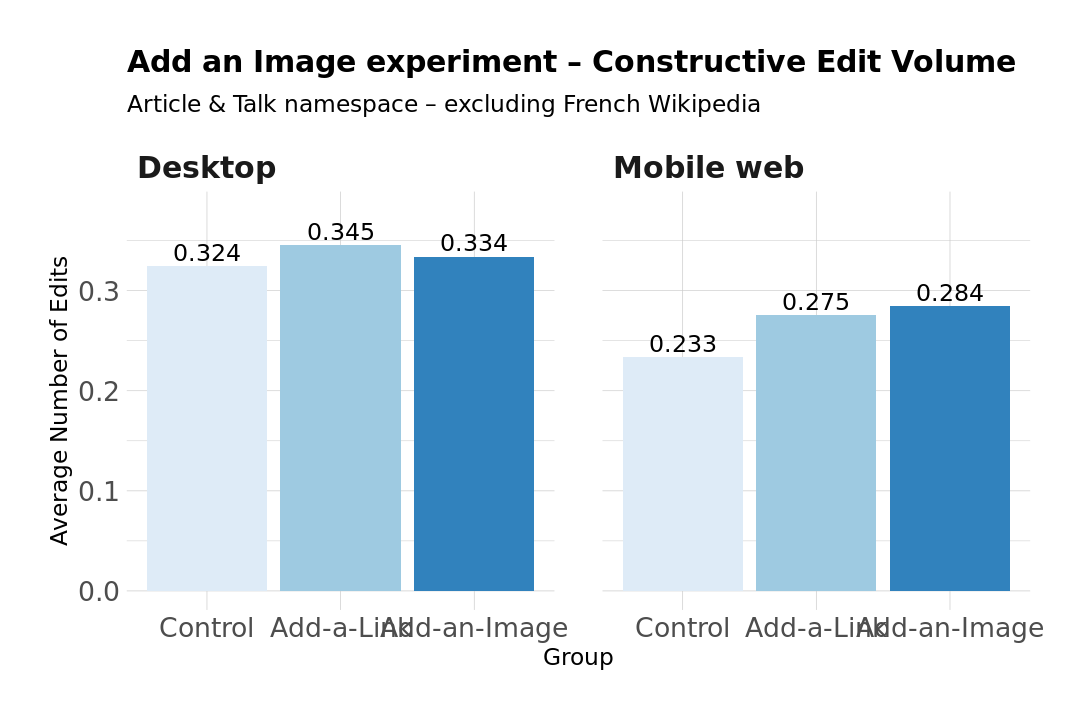

In [67]:
# Give me wider plots, please
options(repr.plot.width = 9, repr.plot.height = 6)

## Note to self: mutate() operates on a per-row basis, summarise() operates on the groups when using group_by()
user_edit_data |>
    filter(wiki_db != 'frwiki') |>
    group_by(platform, exp_group) |>
    summarise(geo_mean = exp(mean(log(1 + num_total_const_article_edits))) -1) |>
    ggplot(aes(x = exp_group, y = geo_mean, fill = exp_group)) +
        labs(title = 'Add an Image experiment – Constructive Edit Volume',
             subtitle = 'Article & Talk namespace – excluding French Wikipedia',
             x = 'Group',
             y = 'Average Number of Edits') +
        hrbrthemes::theme_ipsum("DejaVu Sans", base_size = 16, strip_text_face = "bold", strip_text_size = 18,
                            caption_size = 12, axis_title_size = 14, subtitle_size = 14,
                            axis_title_just = 'cm') +
        guides(fill = 'none') +
        scale_fill_brewer() +
        geom_col() +
        scale_y_continuous(limits = c(0, 0.38)) +
        geom_text(aes(label = round(geo_mean, 3)), fontface = 'plain', nudge_y = 0.014, size = 5) +
        facet_grid(. ~ platform)
ggsave(
    'add-an-image-article-namespace-constructive-edit-volume-2022-experiment.png',
    path = 'graphs',
    width = 16, height = 9, units = "in", dpi = "print", bg = "white")

`summarise()` has grouped output by 'platform'. You can override using the
`.groups` argument.


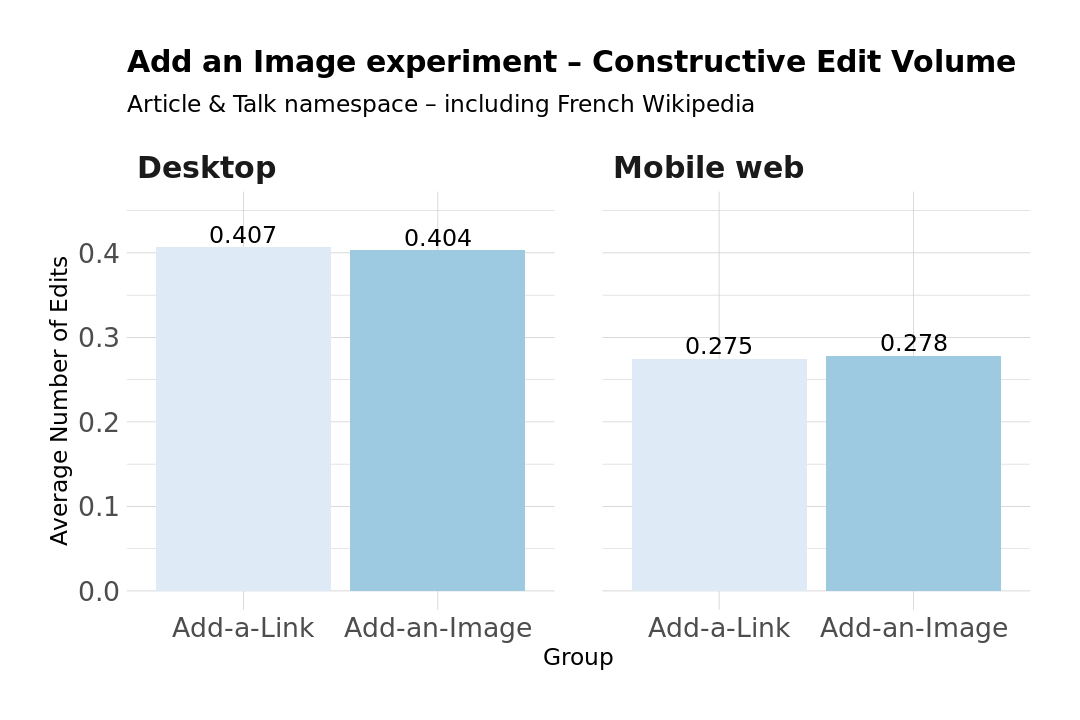

In [72]:
# Give me wider plots, please
options(repr.plot.width = 9, repr.plot.height = 6)

## Note to self: mutate() operates on a per-row basis, summarise() operates on the groups when using group_by()
user_edit_data |>
    filter(exp_group != 'Control') |>
    group_by(platform, exp_group) |>
    summarise(geo_mean = exp(mean(log(1 + num_total_const_article_edits))) -1) |>
    ggplot(aes(x = exp_group, y = geo_mean, fill = exp_group)) +
        labs(title = 'Add an Image experiment – Constructive Edit Volume',
             subtitle = 'Article & Talk namespace – including French Wikipedia',
             x = 'Group',
             y = 'Average Number of Edits') +
        hrbrthemes::theme_ipsum("DejaVu Sans", base_size = 16, strip_text_face = "bold", strip_text_size = 18,
                            caption_size = 12, axis_title_size = 14, subtitle_size = 14,
                            axis_title_just = 'cm') +
        guides(fill = 'none') +
        scale_fill_brewer() +
        geom_col() +
        scale_y_continuous(limits = c(0, 0.45)) +
        geom_text(aes(label = round(geo_mean, 3)), fontface = 'plain', nudge_y = 0.015, size = 5) +
        facet_grid(. ~ platform)
ggsave(
    'add-an-image-article-namespace-constructive-edit-volume-2022-experiment-structured-tasks.png',
    path = 'graphs',
    width = 16, height = 9, units = "in", dpi = "print", bg = "white")